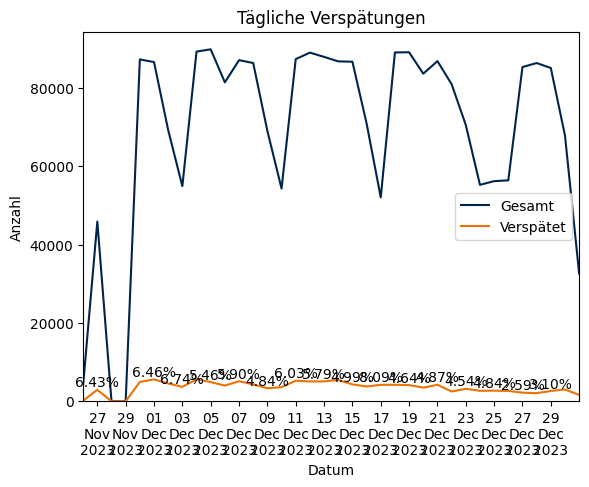

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
from datetime import date, timedelta

# database connection
db = pymysql.connect(host="localhost", user="rnv_importer", password="rnv_importer", database="rnv_big_data_mining")
cursor = db.cursor()

# collect data
day = []
total = []
delayed = []

start_date = date(2023, 11, 26)
end_date = date.today()
# end_date = date(2023, 12, 14)
delta = timedelta(days=1)

# temporary save month and year
current_month = None
current_year = None

while start_date <= end_date:
    day.append(start_date)
    #for debugging
    #print(start_date)

    cursor.execute("SELECT COUNT(*) FROM stops WHERE (DATE(api_plannedDeparture) = %s) AND api_realtimeDeparture IS NOT NULL  ", start_date.strftime("%Y-%m-%d"))
    total.append(cursor.fetchone()[0])

    cursor.execute("SELECT COUNT(*) FROM stops WHERE DATE(api_plannedDeparture) = %s AND api_plannedDeparture != api_realtimeDeparture", start_date.strftime("%Y-%m-%d"))
    delayed.append(cursor.fetchone()[0])

    # check month and year
    if start_date.month != current_month or start_date.year != current_year:
        current_month = start_date.month
        current_year = start_date.year

    start_date += delta

# create DataFrame
df = pd.DataFrame({
    'Gesamt': total,
    'Verspätet': delayed
}, index=day)


# create Plot
fig, ax = plt.subplots()
lines = df.plot.line(ax=ax,color=['#00254C','#ED7200'])

# add text to lines (just for line "delayed" and every second day)
for i, (dt, delayed_count) in enumerate(zip(day, delayed)):
    if (i+1) % 2 == 0 and total[i] != 0 and i != 0 and i != len(day) - 1:  # Nichts anzeigen, wenn das Element das erste oder das letzte ist
        percentage = (delayed_count / total[i]) * 100
        ax.text(dt, delayed_count, f'{percentage:.2f}%', ha='center', va='bottom')

# add axis titles and chart title
plt.xlabel('Datum')
plt.ylabel('Anzahl')
plt.title('Tägliche Verspätungen')

# adjust X-axis-ticks
plt.xticks(day[1:-1:2], [f'{d.strftime("%d")}\n{d.strftime("%b")}\n{d.strftime("%Y")}' for d in day[1:-1:2]], rotation=0, ha='center')

ax.set_xlim([min(day), max(day)])
ax.set_ylim(0)

# show legend
ax.legend()

# show diagramm
plt.show()